# Electrode Analysis with Graph
This analysis is based on the steps carried out in ElectrodeDemo. The final graph shows the amount of unscathed gold by radius, which

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
plt.style.use('evanstyle.mplstyle')

In [3]:
x_min = -4
x_max = 50
y_min = 0
y_max = 6
grid_increment = 2
x_dim = int((x_max-x_min)/grid_increment + 1)
y_dim = int((y_max-y_min)/grid_increment + 1)

gold_area = np.ones((x_dim, y_dim))
gold_area = np.negative(gold_area)

In [4]:
indir = 'Gold Set 2/'
regex = re.compile(r'^y(\d+)_x(\d+)\.JPG$')
filenames = os.listdir(indir)
file_list = [f for f in map(regex.match, filenames) if f is not None]
df = pd.DataFrame()

In [5]:
for f in file_list:
    
    ds = pd.Series(dtype='float64')
    ds['x'] = int(f.group(2))
    #print(str(f.group(1)))
    ds['y'] = int(f.group(1))
    
    
    #load image
    #path_name = 'Gold Set 2/y{}_x{}.JPG'.format(j, i) #flipped
    #print(path_name)
    #src = cv2.imread(path_name)
    print(indir + f.group(0))
    src = cv2.imread(indir + f.group(0))
    
    if src is None: #shouldn't be
        continue
    
    #Create RGB, Grayscale, and Binary transformations
    original = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    imgray = cv2.cvtColor(original,cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(imgray,55,255,cv2.THRESH_BINARY_INV)
    alpha = cv2.GaussianBlur(alpha, (21,21), cv2.BORDER_DEFAULT)
    
    #Using Hough Circle, find scope area
    hough_circle = cv2.HoughCircles(alpha, cv2.HOUGH_GRADIENT, 1.5, 100, param1=50,param2=30,minRadius=0,maxRadius=0)
    hough_circle = np.round(hough_circle[0, 0,:])
    (x,y) = (int(hough_circle[0]), int(hough_circle[1]))
    r = int(hough_circle[2])
    hc_area = np.pi*r**2
    
    #Delete all external area with bitwise_and
    circlemask = np.zeros(original.shape, dtype=np.uint8)
    cv2.circle(circlemask, (x,y), r, (255,255,255), -1)
    circlemask = cv2.cvtColor(circlemask,cv2.COLOR_BGR2GRAY)
    ROI = cv2.bitwise_and(original,original, mask=circlemask)
        
    #Transform to HSV, set upper and lower bounds of gold color, and find binary image with this gold range
    hsvimage = cv2.cvtColor(ROI, cv2.COLOR_RGB2HSV)
    lower = np.array([17, 137, 200], dtype="uint8")
    upper = np.array([50, 190, 255], dtype="uint8")
    goldmask = cv2.inRange(hsvimage, lower, upper)

    #Clean up binary image to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    opening = cv2.morphologyEx(goldmask, cv2.MORPH_OPEN, kernel, iterations=1)

    #Only consider contours with significant area, draw all contours
    cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    cnt_area = 0
    for c in cnts:
        currcontour = cv2.contourArea(c)
        if currcontour >= 2000:
            cnt_area += currcontour
            cv2.drawContours(ROI,[c], 0, (0,0,255), 2)
        
    #Calculating Area:
    perarea = cnt_area/hc_area
    #print('Contour area/Circle area = '+ str(cnt_area)+'/'+ str(hc_area)+' = ' +str(perarea))
    if perarea > 1:
        perarea = 1 
    #print(perarea)
        
    #insert into array
    
    print(str(perarea))
    ds['area'] = perarea
    #print(ds)
    df = df.append(ds, ignore_index=True)
    #print(df)

Gold Set 2/y6_x8.JPG
0.47267456594786034
Gold Set 2/y6_x50.JPG
0.9811208109560846
Gold Set 2/y6_x44.JPG
1
Gold Set 2/y4_x20.JPG
0.2778810413990823
Gold Set 2/y4_x34.JPG
0.825261555743574
Gold Set 2/y0_x14.JPG
0.26296656530348206
Gold Set 2/y0_x28.JPG
0.026449506514057818
Gold Set 2/y0_x16.JPG
0.3127247928372641
Gold Set 2/y4_x22.JPG
0.0033690004472912392
Gold Set 2/y4_x36.JPG
0.8702971404985563
Gold Set 2/y6_x46.JPG
1
Gold Set 2/y6_x42.JPG
1
Gold Set 2/y4_x32.JPG
0.2740071990683431
Gold Set 2/y4_x26.JPG
0.011340367203639764
Gold Set 2/y0_x12.JPG
0.21748358552625124
Gold Set 2/y0_x10.JPG
0.6414555288038771
Gold Set 2/y0_x38.JPG
0.9717070279285996
Gold Set 2/y4_x30.JPG
0.18223010411857044
Gold Set 2/y4_x24.JPG
0.12271770670253612
Gold Set 2/y4_x8.JPG
0.9300629479796261
Gold Set 2/y4_x18.JPG
0.2590022862501792
Gold Set 2/y6_x40.JPG
1
Gold Set 2/y4_x42.JPG
0.8896441210879383
Gold Set 2/y2_x12.JPG
0.3485007284420624
Gold Set 2/y6_x26.JPG
0.08627066122944012
Gold Set 2/y6_x32.JPG
0.437012422

In [18]:
df = df.sort_values(by=['x'])
print(df)
print(df.y.unique())

        area     x    y
59  0.952485   0.0  2.0
77  1.000000   0.0  6.0
94  0.990104   0.0  4.0
51  1.000000   0.0  0.0
70  0.947528   2.0  2.0
..       ...   ...  ...
43  0.874146  46.0  4.0
52  0.963623  48.0  4.0
91  1.000000  48.0  6.0
34  0.432653  50.0  4.0
1   0.981121  50.0  6.0

[99 rows x 3 columns]
[2. 6. 4. 0.]


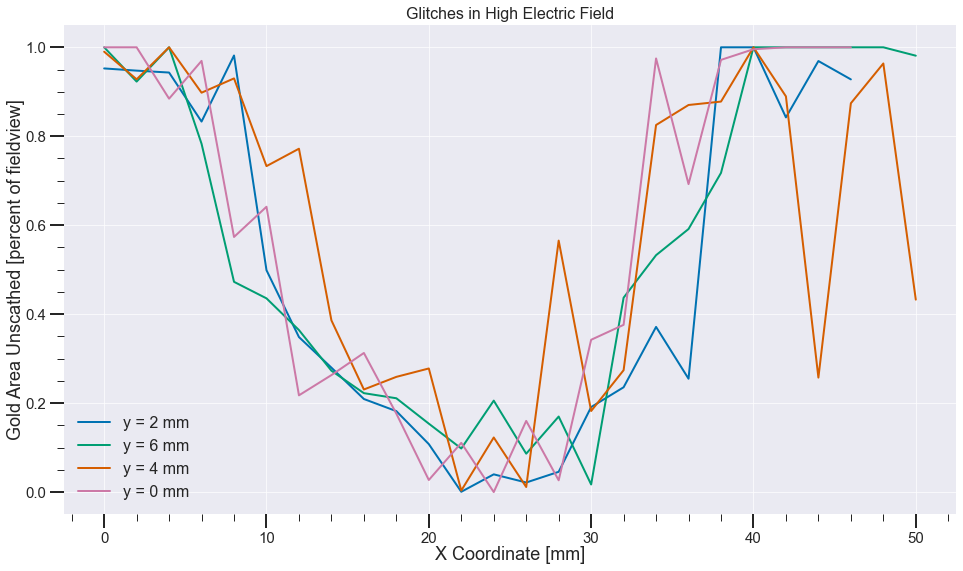

In [38]:
fig = plt.figure(figsize=(16,9))
#fig.set_prop_cycle('color', colors)
for y in df.y.unique():
    mask = (df['y'] == y)
    xs = df['x'][mask]
    areas = df['area'][mask]
    plt.plot(xs, areas, label='y = %d mm' % y)
    
plt.xlabel("X Coordinate [mm]")
plt.ylabel("Gold Area Unscathed [percent of fieldview]")
plt.title("Glitches in High Electric Field")
plt.legend(loc="lower left")
plt.show()